In [1]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc
import mindspore
from mindspore import nn, ops, Tensor
from mindspore.train import Model
import mindspore.numpy as mnp
from mindspore.common.initializer import initializer, XavierUniform
import os
from mindcos.operators.derivatives import grad

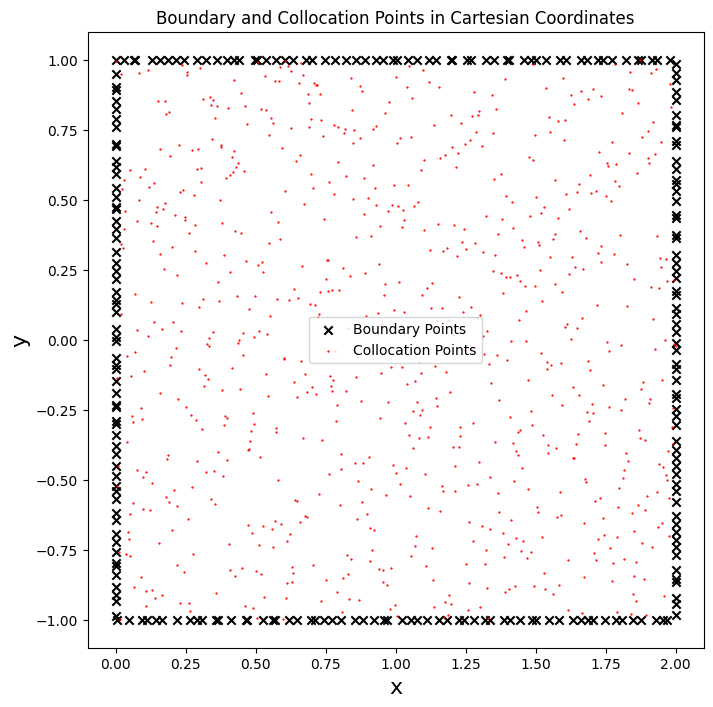

In [2]:
# .......................................................................
# 英文: Solve the Lane-Emden equation in Cartesian coordinates for stellar structure modeling.
# 中文: 在笛卡尔坐标系中求解Lane-Emden方程，用于恒星结构模拟。
# 英文: The equation is solved with flexible boundary conditions (Dirichlet, Neumann, Cauchy, etc.).
# 中文: 该方程支持灵活的边界条件（Dirichlet、Neumann、Cauchy等）。
# .......................................................................

# 英文: Define the exact solution and its derivatives for the Lane-Emden equation
# 中文: 定义Lane-Emden方程的精确解及其导数
def tru(x, y):
    # 英文: Exact solution for the PDE (uncomment alternative for different solution)
    # 中文: PDE的精确解（取消注释以使用不同的解）
    tru = 1 + x * x * y * y
    return tru

def trudx(x, y):
    # 英文: Derivative of the exact solution with respect to x
    # 中文: 精确解对x的导数
    trudx = 2 * x * y * y
    return trudx

def trudy(x, y):
    # 英文: Derivative of the exact solution with respect to y
    # 中文: 精确解对y的导数
    trudy = 2 * y * x * x
    return trudy

# 英文: Data generation on boundaries for a rectangular domain
# 中文: 在矩形域边界上生成数据
# 英文: The boundary points and collocation points are generated for solving
# the Lane-Emden equation, which is used to model polytropic stellar structures.
# These points define the computational domain for simulating stellar interiors.
# 中文: 为求解Lane-Emden方程生成边界点和配点，用于模拟多方程恒星结构。
# 这些点定义了用于模拟恒星内部的计算域。
rmax = 2  # 英文: Maximum x-coordinate / 中文: x坐标最大值
lmax = 1  # 英文: Maximum y-coordinate (half-height) / 中文: y坐标最大值（半高）
n_bc = 4  # 英文: Number of boundary conditions (left, right, bottom, top) / 中文: 边界条件数量（左、右、下、上）
n_data_per_bc = 60  # 英文: Number of data points per boundary / 中文: 每个边界的数据点数量

# 英文: Initialize Latin Hypercube sampler for boundary points
# 中文: 初始化拉丁超立方采样器以生成边界点
engine = qmc.LatinHypercube(d=1)
data = np.zeros([n_bc, n_data_per_bc, 5])  # 英文: Store x, y, value, dx, dy / 中文: 存储x、y、值、dx、dy

# 英文: Generate boundary points for the rectangular domain
# 中文: 为矩形域生成边界点
for i, j in zip(range(n_bc), [0., 1., 0, 1.]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.) * 1  # 英文: Random sampling / 中文: 随机采样
    # points = np.linspace(0, +1, n_data_per_bc)  # 英文: Alternative: Linear sampling (commented) / 中文: 替代方案：线性采样（已注释）
    
    if i < 2:  # 英文: Left and right boundaries / 中文: 左边界和右边界
        data[i, :, 0] = j + 0.
        data[i, :, 1] = points - 0.
    else:  # 英文: Bottom and top boundaries / 中文: 下边界和上边界
        data[i, :, 0] = points + 0.
        data[i, :, 1] = j - 0.

# 英文: Scale boundary points to the domain
# 中文: 将边界点缩放到计算域
data[:, :, 0] = rmax * data[:, :, 0]
data[:, :, 1] = 2 * lmax * data[:, :, 1] - 1

# 英文: Assign exact solution and derivatives to boundary points
# 中文: 为边界点分配精确解及其导数
for j in range(0, n_data_per_bc):
    # 英文: Left boundary / 中文: 左边界
    data[0, j, 2] = tru(data[0, j, 0], data[0, j, 1])
    data[0, j, 3] = trudx(data[0, j, 0], data[0, j, 1])
    data[0, j, 4] = trudy(data[0, j, 0], data[0, j, 1])

    # 英文: Right boundary / 中文: 右边界
    data[1, j, 2] = tru(data[1, j, 0], data[1, j, 1])
    data[1, j, 3] = trudx(data[1, j, 0], data[1, j, 1])
    data[1, j, 4] = trudy(data[1, j, 0], data[1, j, 1])
    
    # 英文: Bottom boundary / 中文: 下边界
    data[2, j, 2] = tru(data[2, j, 0], data[2, j, 1])
    data[2, j, 3] = trudx(data[2, j, 0], data[2, j, 1])
    data[2, j, 4] = trudy(data[2, j, 0], data[2, j, 1])

    # 英文: Top boundary / 中文: 上边界
    data[3, j, 2] = tru(data[3, j, 0], data[3, j, 1])
    data[3, j, 3] = trudx(data[3, j, 0], data[3, j, 1])
    data[3, j, 4] = trudy(data[3, j, 0], data[3, j, 1])

# 英文: Reshape boundary data
# 中文: 重塑边界数据
data = data.reshape(n_data_per_bc * n_bc, 5)

# 英文: Expand dimensions for x, y, value, and derivatives
# 中文: 为x、y、值和导数扩展维度
x_d, y_d, t_d, t_dx, t_dy = map(lambda x: np.expand_dims(x, axis=1), 
                                 [data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4]])

# 英文: Generate collocation points for the PDE residual using Latin Hypercube Sampling
# 中文: 使用拉丁超立方采样生成PDE残差的配点
Nc = 800  # 英文: Number of collocation points / 中文: 配点数量
engine = qmc.LatinHypercube(d=2)  # 英文: Initialize Latin Hypercube sampler / 中文: 初始化拉丁超立方采样器
colloc = engine.random(n=Nc)  # 英文: Generate random points / 中文: 生成随机点
colloc = 1 * (colloc - 0)  # 英文: Normalize points / 中文: 归一化点

# 英文: Scale collocation points to the domain
# 中文: 将配点缩放到计算域
colloc[:, 0] = rmax * colloc[:, 0]
colloc[:, 1] = 2 * lmax * colloc[:, 1] - 1

# 英文: Expand dimensions for collocation points
# 中文: 为配点扩展维度
x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), [colloc[:, 0], colloc[:, 1]])

# 英文: Visualize boundary and collocation points
# 中文: 可视化边界点和配点
plt.figure(figsize=(8, 8))
plt.title("Boundary and Collocation Points in Cartesian Coordinates")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="Boundary Points")
plt.scatter(colloc[:, 0], colloc[:, 1], s=1.5, marker=".", c="r", label="Collocation Points")
plt.xlabel("x", fontsize=16)
plt.ylabel("y", fontsize=16)
plt.axis("square")
plt.legend()
plt.savefig('boundary_and_collocation_points.png')  # 英文: Save as descriptive filename / 中文: 保存为描述性文件名
plt.show()
plt.close()

# 英文: Convert data to MindSpore tensors
# 中文: 将数据转换为MindSpore张量
x_c, y_c, x_d, y_d, t_d, t_dx, t_dy = map(lambda x: Tensor(x, dtype=mindspore.float32),
                                           [x_c, y_c, x_d, y_d, t_d, t_dx, t_dy])


In [3]:
# 英文: Define the Deep Neural Network (DNN) for the PINN
# 中文: 定义用于PINN的深度神经网络（DNN）
class DNN(nn.Cell):
    def __init__(self, in_shape=2, out_shape=1, n_hidden_layers=7, neuron_per_layer=20):
        super(DNN, self).__init__()
        self.layers = nn.SequentialCell()
        # 英文: Add input layer to first hidden layer / 中文: 添加输入层到第一个隐藏层
        self.layers.append(nn.Dense(in_shape, neuron_per_layer))
        self.layers.append(nn.Tanh())
        # 英文: Add remaining hidden layers / 中文: 添加剩余的隐藏层
        for _ in range(n_hidden_layers - 1):
            self.layers.append(nn.Dense(neuron_per_layer, neuron_per_layer))
            self.layers.append(nn.Tanh())
        # 英文: Add output layer / 中文: 添加输出层
        self.layers.append(nn.Dense(neuron_per_layer, out_shape))

    def construct(self, x, y):
        inputs = ops.Concat(axis=1)((x, y))  # 英文: Concatenate inputs / 中文: 拼接输入
        t = self.layers(inputs)
        return t

# 英文: Build the DNN model with specified architecture
# 中文: 使用指定架构构建DNN模型
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=5, neuron_per_layer=20):
    model = DNN(in_shape, out_shape, n_hidden_layers, neuron_per_layer)
    return model

# 英文: Define the loss function for the Physics-Informed Neural Network (PINN)
# 中文: 定义物理信息神经网络（PINN）的损失函数
class Loss(nn.Cell):
    def __init__(self):
        super(Loss, self).__init__()

    def mse(self, u, t):
        # 英文: Compute Mean Squared Error / 中文: 计算均方误差
        return ops.ReduceMean()(ops.Square()(u - t))

    def pde_loss(self, model, x_c, y_c):
        x = x_c
        y = y_c
        # 英文: Compute first and second derivatives for the PDE
        # 中文: 计算PDE的一阶和二阶导数
        du_dx_fn = grad(model, 0, 0)
        du_dy_fn = grad(model, 0, 1)
        du2_dx2_fn = grad(du_dx_fn, 0, 0)
        du2_dy2_fn = grad(du_dy_fn, 0, 1)
        
        du_dx = du_dx_fn(x, y)
        du2_dx2 = du2_dx2_fn(x, y)
        du_dy = du_dy_fn(x, y)
        du2_dy2 = du2_dy2_fn(x, y)
    
        del du_dx_fn, du_dy_fn, du2_dx2_fn, du2_dy2_fn
        
        # 英文: Lane-Emden PDE residual / 中文: Lane-Emden PDE残差
        F = x * y * du2_dx2 + 1 * y * du_dx + x * y * du2_dy2 + 1 * x * du_dy - 4 * x * y * (x * x + y * y)
        return ops.ReduceMean()(ops.Square()(F))
        
    def msex1(self, y, y_):
        # 英文: MSE for left boundary / 中文: 左边界的均方误差
        yr = y.reshape(n_bc, n_data_per_bc)
        yr_ = y_.reshape(n_bc, n_data_per_bc)
        yrr = yr[0, :]
        yrr_ = yr_[0, :]        
        retour = ops.ReduceMean()(ops.Square()(yrr - yrr_))
        return retour

    def msex2(self, y, y_):
        # 英文: MSE for right boundary / 中文: 右边界的均方误差
        yr = y.reshape(n_bc, n_data_per_bc)
        yr_ = y_.reshape(n_bc, n_data_per_bc)
        yrr = yr[1, :]
        yrr_ = yr_[1, :]        
        retour = ops.ReduceMean()(ops.Square()(yrr - yrr_))
        return retour

    def msey1(self, y, y_):
        # 英文: MSE for bottom boundary / 中文: 下边界的均方误差
        yr = y.reshape(n_bc, n_data_per_bc)
        yr_ = y_.reshape(n_bc, n_data_per_bc)
        yrr = yr[2, :]
        yrr_ = yr_[2, :]        
        retour = ops.ReduceMean()(ops.Square()(yrr - yrr_))
        return retour    

    def msey2(self, y, y_):
        # 英文: MSE for top boundary / 中文: 上边界的均方误差
        yr = y.reshape(n_bc, n_data_per_bc)
        yr_ = y_.reshape(n_bc, n_data_per_bc)
        yrr = yr[3, :]
        yrr_ = yr_[3, :]        
        retour = ops.ReduceMean()(ops.Square()(yrr - yrr_))
        return retour    
        
    def construct(self, model, xc, yc, xd, yd, t_d, t_dx, t_dy, ep):
        T_ = model(xd, yd)
        Tderx_ = grad(model, 0, 0)(x_d, y_d)
        Tdery_ = grad(model, 0, 1)(x_d, y_d)
        
        # 英文: Combine PDE and boundary condition losses
        # 中文: 组合PDE和边界条件损失
        loss_pde = self.pde_loss(model, xc, yc)
        loss_mse = self.msex1(t_d, T_) + self.msex2(t_d, T_) + self.msey1(t_d, T_) + self.msey2(t_d, T_)
        loss = loss_mse + loss_pde
        return loss

# 英文: Initialize network, optimizer, and loss function
# 中文: 初始化网络、优化器和损失函数
network = DNN_builder(2, 1, 5, 20)
optimizer = nn.optim.Adam(network.trainable_params(), learning_rate=3e-4)
loss_fn = Loss()

# 英文: Define forward function for gradient computation
# 中文: 定义用于梯度计算的前向函数
def forward_fn(xc, yc, xd, yd, t_d, t_dx, t_dy, ep):
    loss = loss_fn(network, xc, yc, xd, yd, t_d, t_dx, t_dy, ep)
    return loss

# 英文: Compute gradients and update parameters
# 中文: 计算梯度并更新参数
grad_fn = mindspore.value_and_grad(forward_fn, None, optimizer.parameters, has_aux=False)

# 英文: Training step function
# 中文: 训练步骤函数
def train_step(xc, yc, xd, yd, t_d, t_dx, t_dy, ep):
    (loss), grads = grad_fn(xc, yc, xd, yd, t_d, t_dx, t_dy, ep)
    optimizer(grads)
    return loss

# 英文: Training loop
# 中文: 训练循环
def train_loop(model, xc, yc, xd, yd, t_d, t_dx, t_dy, ep):
    model.set_train()
    loss = train_step(xc, yc, xd, yd, t_d, t_dx, t_dy, ep)
    return loss

# 英文: Testing loop to evaluate loss
# 中文: 测试循环以评估损失
def test_loop(model, xd, yd, t_d, t_dx, t_dy):
    model.set_train(False)
    pred = model(xd, yd)
    loss_test = loss_fn.mse(pred, t_d)
    return loss_test

[WARNING] DEVICE(165889,ffffa2c1d020,python):2025-08-03-00:55:11.360.896 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:149] CheckVmmDriverVersion] Open file /etc/ascend_install.info failed.
[WARNING] DEVICE(165889,ffffa2c1d020,python):2025-08-03-00:55:11.360.975 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_vmm_adapter.h:177] CheckVmmDriverVersion] Open file /usr/local/Ascend/driver/version.info failed.


In [4]:
# 英文: Plotting function for visualizing results
# 中文: 用于可视化结果的绘制函数
# 英文: Note: This function plots the PINN solution, exact solution, and errors
# 中文: 注意：此函数绘制PINN解、精确解和误差
def plot(network, ep):
    n = 200
    l = 1.
    r = 2 * l / (n + 1)
    T = np.zeros([n * n, n * n])

    # 英文: Set up grid for visualization
    # 中文: 设置可视化网格
    plt.figure(figsize=(14, 7))
    lim1 = lmax
    lim2 = rmax
    X = np.linspace(0.000, lim2, n)
    Y = np.linspace(-lim1, lim1, n)
    X0, Y0 = np.meshgrid(X, Y)
    X = X0.reshape([n * n, 1])
    Y = Y0.reshape([n * n, 1])
    X_T = Tensor(X, dtype=mindspore.float32)
    Y_T = Tensor(Y, dtype=mindspore.float32)

    # 英文: Compute predicted solution
    # 中文: 计算预测解
    S = network(X_T, Y_T)
    S = S.numpy().reshape(n, n)
    S2 = S

    # 英文: Plot PINN solution
    # 中文: 绘制PINN解
    plt.subplot(221)
    plt.pcolormesh(X0, Y0, S2, cmap="viridis_r")
    plt.contour(X0, Y0, S2, 15, linestyles='dashed', linewidths=1.5)
    plt.colorbar(pad=-0.25)
    plt.xlabel("X", fontsize=16)
    plt.ylabel("Y", fontsize=16)
    plt.xlim(0, lim2)
    plt.ylim(0, lim1)
    plt.title("PINN Solution", fontsize=16)
    plt.tight_layout()
    plt.axis("square")

    # 英文: Compute and plot relative error
    # 中文: 计算并绘制相对误差
    TT = tru(X0, Y0)
    TT2 = (TT - S2) / TT
    plt.subplot(222)
    plt.pcolormesh(X0, Y0, TT2, cmap="turbo")
    plt.colorbar(pad=-0.25)
    plt.xlabel("X", fontsize=16)
    plt.ylabel("Y", fontsize=16)
    plt.xlim(0, lim2)
    plt.ylim(-lim1, lim1)
    plt.title("Relative Error", fontsize=16)
    plt.tight_layout()
    plt.axis("square")
    
    # 英文: Plot exact solution
    # 中文: 绘制精确解
    TT = tru(X0, Y0)
    plt.subplot(223)
    plt.pcolormesh(X0, Y0, TT, cmap="turbo")
    plt.colorbar(pad=-0.25)
    plt.xlabel("X", fontsize=16)
    plt.ylabel("Y", fontsize=16)
    plt.xlim(0, lim2)
    plt.ylim(-lim1, lim1)
    plt.title("Exact Solution", fontsize=16)
    plt.tight_layout()
    plt.axis("square")
    
    # 英文: Plot absolute error
    # 中文: 绘制绝对误差
    TT2 = TT - S2
    plt.subplot(224)
    plt.pcolormesh(X0, Y0, TT2, cmap="turbo")
    plt.colorbar(pad=-0.25)
    plt.xlabel("X", fontsize=16)
    plt.ylabel("Y", fontsize=16)
    plt.xlim(0, lim2)
    plt.ylim(-lim1, lim1)
    plt.title("Absolute Error", fontsize=16)
    plt.tight_layout()
    plt.axis("square")

    plt.savefig(f'lane_emden_solution_ep{ep}.png')  # 英文: Save as descriptive filename / 中文: 保存为描述性文件名
    plt.close()


In [ ]:
# 英文: Check device target (CPU/GPU/Ascend)
# 中文: 检查设备目标（CPU/GPU/Ascend）
device_target = mindspore.context.get_context("device_target")
print("Current device target:", device_target)

# 英文: Initialize training parameters
# 中文: 初始化训练参数
loss = 0
epochs = 50000
epoch = 0
loss_values = np.array([])  # 英文: Store total loss / 中文: 存储总损失
L_values = np.array([])  # 英文: Store PDE loss (unused) / 中文: 存储PDE损失（未使用）
l_values = np.array([])  # 英文: Store MSE loss (unused) / 中文: 存储MSE损失（未使用）
lp_values = np.array([])  # 英文: Unused array / 中文: 未使用数组
log_dir = './log/Lane_Emden'
os.makedirs(log_dir, exist_ok=True)
with open(f'{log_dir}/train.log', 'w') as f:
    f.write('\nepoch, loss, time\n')

# 英文: Start training and track best model
# 中文: 开始训练并跟踪最佳模型
start = time.time()
loss_test = 1e9
best_network = None
best_ep = 0

for epoch in range(epochs):
    loss = train_loop(network, x_c, y_c, x_d, y_d, t_d, t_dx, t_dy, epoch)
    if epoch % 1 == 0 or epoch == epochs - 1:
        loss_values = np.append(loss_values, loss)
        with open(f'{log_dir}/train.log', 'a') as f:
            f.write(f'{epoch + 1}, {loss}, {time.time() - start:.1f}\n')
        _loss_test = test_loop(network, x_d, y_d, t_d, t_dx, t_dy)
        if loss_test > _loss_test:
            best_network = network    
            best_ep = epoch
    if epoch % 1000 == 0:
        print(f"Epoch {epoch + 1} {loss}, {time.time() - start:.1f}\n-------------------------------")
        network.set_train(False)
        plot(network, epoch)

# 英文: Record computation time
# 中文: 记录计算时间
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\nComputation time: {end - start:.3f}\n")

# 英文: Plot loss curve
# 中文: 绘制损失曲线
plt.semilogy(loss_values)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('training_loss_curve.png')  # 英文: Save as descriptive filename / 中文: 保存为描述性文件名
plt.close()

network.set_train(False)
plot(best_network, best_ep)

Current device target: Ascend
Epoch 1 93.15261, 9.0
-------------------------------
Epoch 1001 0.55908245, 449.2
-------------------------------
Epoch 2001 0.04624991, 895.0
-------------------------------
Epoch 3001 0.008205557, 1403.0
-------------------------------
Epoch 4001 0.004353698, 1954.0
-------------------------------
Epoch 5001 0.0030989335, 2542.5
-------------------------------
Epoch 6001 0.0024018106, 3166.3
-------------------------------
Epoch 7001 0.0019487827, 3807.3
-------------------------------
Epoch 8001 0.0019091035, 4507.8
-------------------------------
Epoch 9001 0.0013790765, 5261.2
-------------------------------
Epoch 10001 0.0011985363, 6036.8
-------------------------------
Epoch 11001 0.00096015516, 6824.4
-------------------------------
Epoch 12001 0.0007565256, 7637.9
-------------------------------
Epoch 13001 0.0008956949, 8486.4
-------------------------------
Epoch 14001 0.0011913853, 9460.7
-------------------------------
Epoch 15001 0.00032667